In [ ]:
import sys

sys.path.append("../")

import sqlite3
import matplotlib.pyplot as plt
from src.cmesrc.config import CMESRC_DB
import numpy as np

In [15]:
conn = sqlite3.connect(CMESRC_DB)
conn.execute("PRAGMA foreign_keys = ON")
cur = conn.cursor()

In [16]:
def get_rows_grouped_by_year(harpnum):
    con = sqlite3.connect(CMESRC_DB)
    con.execute("PRAGMA foreign_keys = ON")
    cur = con.cursor()

    cur.execute(
        f"""
        SELECT DISTINCT strftime('%Y', timestamp) FROM cutouts_for_download WHERE harpnum= ?
    """, (harpnum,))

    years = [row[0] for row in cur.fetchall()]

    rows = dict()

    for year in years:
        cur.execute("DROP TABLE IF EXISTS cutouts_for_download_temp")

        cur.execute(
            f"""
            CREATE TEMPORARY TABLE cutouts_for_download_temp AS
            SELECT hpb.timestamp, hpb.x_cen, hpb.y_cen, hpbs.width, hpbs.height, i.idx
            FROM cutouts_for_download cfd 
            INNER JOIN harps_pixel_bbox hpb ON cfd.harpnum = hpb.harpnum AND cfd.timestamp = hpb.timestamp
            INNER JOIN images i ON cfd.timestamp = i.timestamp
            INNER JOIN harps_pixel_bbox_sizes hpbs ON hpb.harpnum = hpbs.harpnum
            WHERE cfd.harpnum= ? AND strftime('%Y', cfd.timestamp) = ?
        """, (harpnum, year))

        cur.execute(
            """
            WITH cutouts_hours AS (
            SELECT *,
                strftime('%Y-%m-%d %H:00:00', timestamp) AS hour,
                ABS(julianday(timestamp) - julianday(strftime('%Y-%m-%d %H:00:00', timestamp))) * 24 * 60 * 60 AS diff
            FROM cutouts_for_download_temp
            )

            SELECT timestamp, x_cen, y_cen, width, height, idx FROM (
            SELECT *,
                RANK() OVER (PARTITION BY hour ORDER BY diff ASC) AS rank
                FROM cutouts_hours
            )
            WHERE rank = 1
            """
        )

        rows[year] = cur.fetchall()

    con.close()

    total_rows = sum([len(rows[year]) for year in years])

    if total_rows == 0:
        raise ValueError(f"No rows found for HARP {harpnum}")

    width, height = rows[years[0]][0][3], rows[years[0]][0][4]

    return rows, total_rows, (width, height)

2011: 178
False
0.6193181818181818 0.3693181818181818
0.07954545454545454 0.08522727272727272


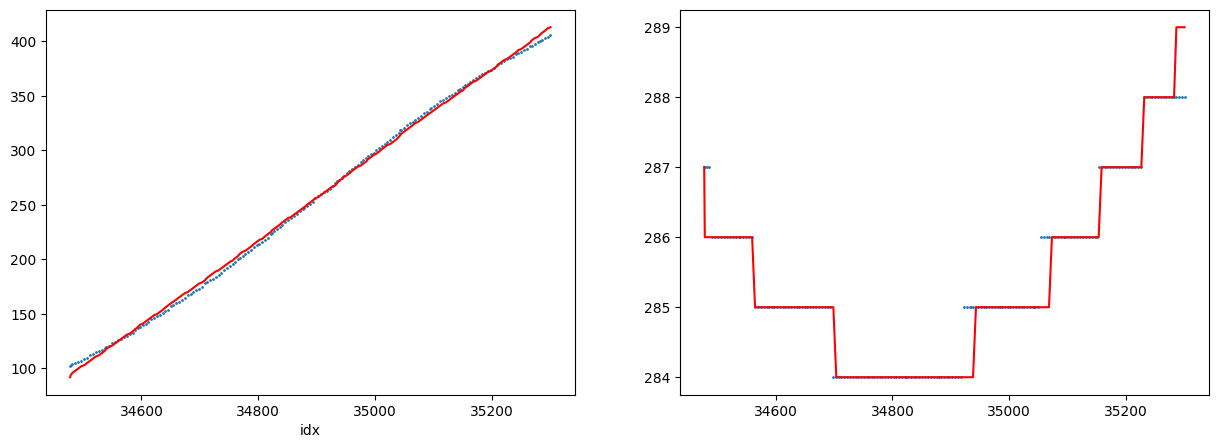

In [44]:
from scipy.signal import savgol_filter

def smooth_with_savgol(arr, window_length=5, polyorder=2):
    return savgol_filter(arr, window_length, polyorder)

def calculate_smoothness_second_derivative(arr):
    return np.mean(np.abs(np.diff(np.diff(arr))))

all_rows = get_rows_grouped_by_year(1062)[0]

for year,rows in all_rows.items():
    print(f"{year}: {len(all_rows[year])}")

    timestamps, x_cen, y_cen, n_width, n_height, idx = zip(*rows)

    fig, ax = plt.subplots(ncols=2, figsize=(15, 5))

    ax[0].scatter(idx, x_cen, s=1)
    ax[0].set_xlabel("idx")
    
    ax[1].scatter(idx, y_cen, s=1)

    kernel_size = 10

    kernel = np.ones(kernel_size) / kernel_size

    convolved_x_cen = smooth_with_savgol(x_cen, window_length=len(x_cen), polyorder=1)
    convolved_y_cen = smooth_with_savgol(y_cen, window_length=len(y_cen), polyorder=2)

    convolved_x_cen = np.round(convolved_x_cen).astype(int)
    convolved_y_cen = np.round(convolved_y_cen).astype(int)

    ax[0].plot(idx, convolved_x_cen, color="red")
    ax[1].plot(idx, convolved_y_cen, color="red")

    print(np.any(np.diff(x_cen) < 0))

    print(calculate_smoothness_second_derivative(x_cen), calculate_smoothness_second_derivative(convolved_x_cen))
    print(calculate_smoothness_second_derivative(y_cen), calculate_smoothness_second_derivative(convolved_y_cen))


    break

In [45]:
    con = sqlite3.connect(CMESRC_DB)
    con.execute("PRAGMA foreign_keys = ON")
    cur = con.cursor()

    cur.execute(
        """
        CREATE TABLE IF NOT EXISTS cutouts_for_download_processed (
            harpnum INTEGER NOT NULL,
            PRIMARY KEY (harpnum),
            FOREIGN KEY (harpnum) REFERENCES harps (harpnum)
            )
    """
    )

    # Select only harps that have not been processed yet
    cur.execute(
        """
        SELECT DISTINCT cfd.harpnum FROM cutouts_for_download cfd
        LEFT JOIN cutouts_for_download_processed cfdp ON cfd.harpnum = cfdp.harpnum
        WHERE cfdp.harpnum IS NULL
    """
    )

    harpnums_to_process = sorted([row[0] for row in cur.fetchall()])

In [48]:
cur.execute("SELECT harpnum, width, height from harps_pixel_bbox_sizes")
harps_sizes = cur.fetchall()

widths = []
heights = []

for harpnum, width, height in harps_sizes:
    width = width + width % 2
    height = height + height % 2

    widths.append(width)
    heights.append(height)
    


Text(0, 0.5, 'Height')

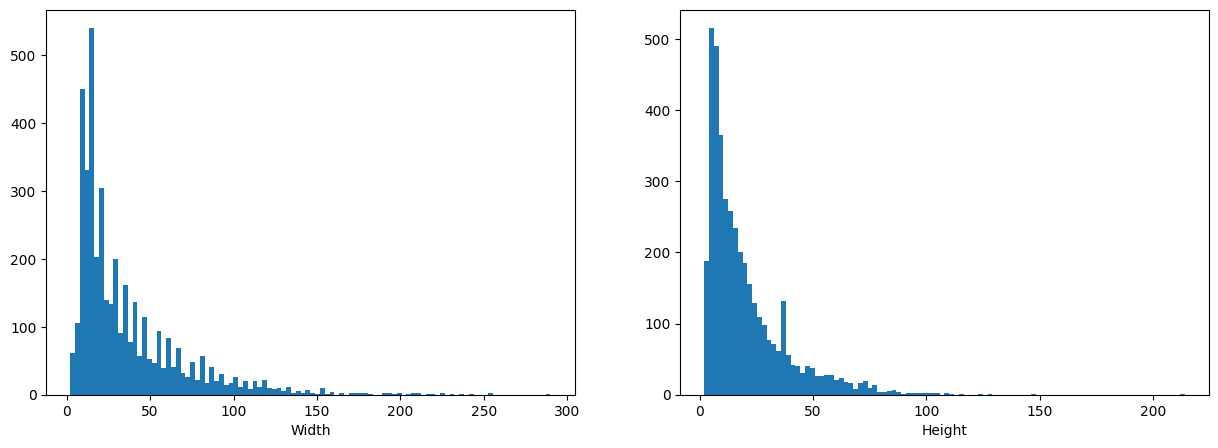

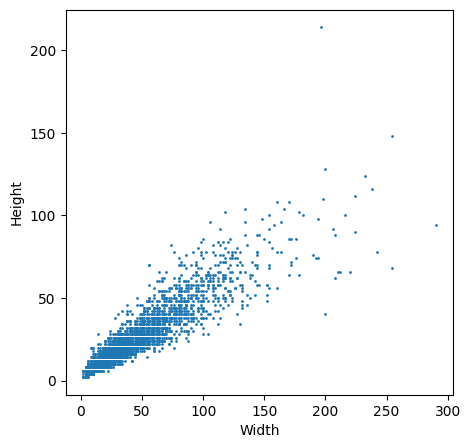

In [50]:
# Describe the distribution of widths and heights

fig, ax = plt.subplots(ncols=2, figsize=(15, 5))

ax[0].hist(widths, bins=100)
ax[0].set_xlabel("Width")

ax[1].hist(heights, bins=100)
ax[1].set_xlabel("Height")

# What's the correlation?

plt.figure(figsize=(5, 5))
plt.scatter(widths, heights, s=1)
plt.xlabel("Width")
plt.ylabel("Height")

In [51]:
# How many have width larger than 50?

np.sum(np.array(widths) > 50)

935

In [52]:
# larger than 100?

np.sum(np.array(widths) > 100)

219

In [53]:
# Larger than 30?

np.sum(np.array(widths) > 30)

1626

In [ ]:
# Meh I think larger than 30 width is enough